Title: Spherical NFW simuleted data
    
Date: 08/03/2020

Obj: Simulate an source galaxy and deflect it using an Spherical NFW mass model.

In [127]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
print(al.__version__)

1.1.4


In [128]:
#Defing the grid
grid = al.Grid.uniform(shape_2d=(80, 80), pixel_scales=0.1, sub_size=1)
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.1, pixel_scales=0.1)

In [150]:
#Defing the mass model
NFW_profile = al.mp.SphericalNFW(centre=(0.0, 0.0), scale_radius=25, kappa_s = 0.13)
lens_galaxy = al.Galaxy(
    redshift=0.035,
    mass=NFW_profile,
)

einstein_mass = NFW_profile.einstein_mass_in_units(
    unit_mass="solMass", redshift_object=0.035, redshift_source=2.1
)

rs_mass = NFW_profile.mass_within_circle_in_units(unit_mass="solMass", redshift_object=0.035,
                                               redshift_source=2.1, radius=25)


print('Einstein Ring in arcsec:', NFW_profile.einstein_radius_in_units())
print('Mass inside Einstein Ring in solMass:{:.4e}'.format(einstein_mass))
print('Mass inside scale radius in solMass:{:.4e}'.format(rs_mass))
print('\n')
print('Lens galaxy:\n',lens_galaxy)

Einstein Ring in arcsec: 0.6414960650428684
Mass inside Einstein Ring in solMass:7.7180e+09
Mass inside scale radius in solMass:1.8704e+12


Lens galaxy:
 Redshift: 0.035
Mass Profiles:
SphericalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
kappa_s: 0.13
scale_radius: 25.0
inner_slope: 1.0


In [130]:
#Defining the source model
source_galaxy = al.Galaxy(
    redshift=2.1,
    light=al.lp.EllipticalSersic(
        centre=(-0.1, 0.1),
        elliptical_comps=(0.3, 0.111111),
        intensity=0.85,
        effective_radius=0.8,
        sersic_index=2,
    ),
)

print(source_galaxy)

Redshift: 2.1
Light Profiles:
EllipticalSersic
centre: (-0.1, 0.1)
elliptical_comps: (0.3, 0.111111)
axis_ratio: 0.5152490035093175
phi: 34.8384409156042
intensity: 0.85
effective_radius: 0.8
sersic_index: 2.0


In [131]:
#Ray tracing the source galaxy
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

In [132]:
mask = al.Mask.circular(
    shape_2d=grid.shape_2d, pixel_scales=grid.pixel_scales, sub_size=1,radius=3 ,centre=(0, 0)
)


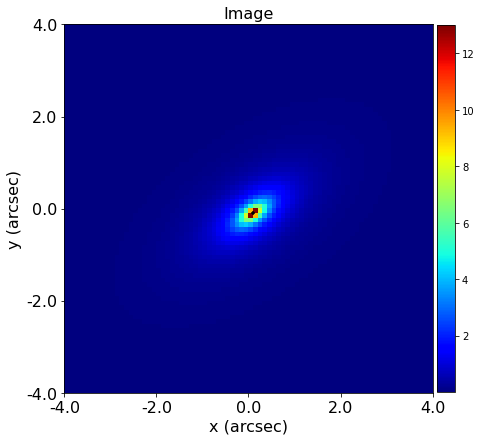

In [133]:
#Save image of source galaxy and plot it
plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical NFW/Image Output/',
                                          filename='Source Galaxy',
                                           format='png'),
                       labels=aplt.Labels(title='Source Galaxy'),             
                      )

aplt.Galaxy.image(galaxy=source_galaxy, grid=grid, 
                  plotter=plotter)
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)

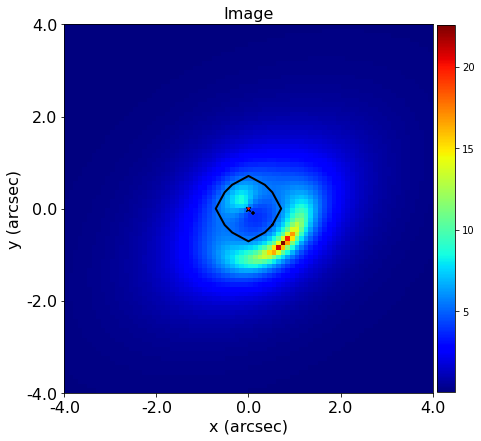

In [134]:
#Save image of arcs and plot it
plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical NFW/Image Output/',
                                          filename='Arcs',
                                           format='png'),
                       labels=aplt.Labels(title='Arcs'),             
                      )
aplt.Tracer.image(tracer=tracer, grid=grid, plotter=plotter)
aplt.Tracer.image(tracer=tracer, grid=grid)

In [135]:
#Just some infos about shape of the image after convolution with PSF
normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_2d
)
print(normal_image.shape)
print(padded_image.shape)

(6400,)
(8100,)


In [136]:
#Simulating the arcs image: Add Noise and PSF
simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

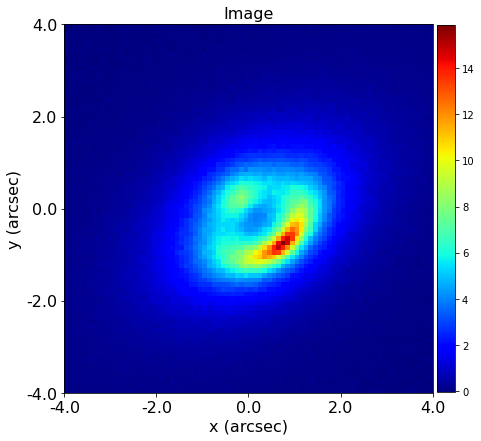

In [137]:
#Plot simulated image and save it
plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical NFW/Image Output/',
                                          filename='Simulated Arcs',
                                           format='png'),
                       labels=aplt.Labels(title='Arcs with Noise and PSF'),             
                      )
aplt.Imaging.image(imaging=imaging, plotter=plotter)
aplt.Imaging.image(imaging=imaging)

In [138]:
from pyprojroot import here

workspace_path = str(here())
dataset_path = f"{workspace_path}/howtolens/Testes with MGE/Spherical NFW/Data"
print("Dataset Path: ", dataset_path)

Dataset Path:  /home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical NFW/Data


In [139]:
#Save the simulated image in .fits file
imaging.output_to_fits(
    image_path=f"{dataset_path}/ImageNFW.fits",
    noise_map_path=f"{dataset_path}/NoiseNFW.fits",
    psf_path=f"{dataset_path}/PSFNFW.fits",
    overwrite=True,
)